# [Writing Custom Datasets, Dataloaders and Transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)
- non-trivial dataset에서 데이터를 load하고 전처리 하는 방법에 대한 튜토리얼

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
# csv 읽어서 사이즈 (N, 2) 의 annotation을 얻는다(N: number of landmarks)

landmarks_frame = pd.read_csv('./data/faces/face_landmarks.csv')

# 65번째 이미지 확인
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks) # 데이터를 배열로 만들어주기
landmarks = landmarks.astype('float').reshape(-1, 2) # (x, y) 형태로 만들어주기

## Dataset Class
- torch.utils.data.Dataset: dataset을 표현하는 추상 클래스
    - 커스텀 데이터셋들은 Dataset 클래스를 상속받고 다음과 같은 메서드를 오버라이딩 해야 한다.
        - __len__: len(dataset)이 데이터셋의 사이즈를 리턴할 수 있도록 만들어 주어야 한다.
        - __getitem__: dataset[i]이 i번째 샘플을 가리킬 수 있도록 만들어준다.
- 이 face landmark 데이터셋을 위한 dataset class를 만들어보자.
    - __init__: csv 파일 읽기
    - __getitem__: image 읽는 것은 여기서 수행
        - 모든 이미지가 메모리에 저장되지 않고 하나씩 읽을 수 있기 때문에 효율적
    - 최종적으로 데이터셋 샘플은 다음과 같은 형식을 가진다: {'image': image, 'landmarks': landmarks}
    - 추가적으로 transform이라는 argument를 가지게 되는데, 이를 통해 이미지를 처리할 수 있게 된다.

In [3]:
class FaceLandmarksDataset(Dataset):
    """
    Face Landmarks Dataset
    """
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        args:
        - csv_file(string): path to the csv file with annotations
        - root_dir(string): directory with all the images
        - transform(callable, optional): optional transform to be applied on a sample
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

- class 초기화하고 데이터 샘플 전체에 대해 iterate 진행

In [4]:
face_dataset = FaceLandmarksDataset(csv_file='./data/faces/face_landmarks.csv', root_dir='./data/faces')

In [5]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated


# Transforms
- 뉴럴 네트워크에서 학습을 진행하기 위해서는 샘플 데이터셋들의 크기가 고정이 되어야 한다.
    - 이를 위한 전처리 코드를 만들어 보자.
- Rescale: image scaling 위한 클래스
- RandomCrop: 이미지를 랜덤으로 자르기 위해(data augmentation)
- ToTensor: numpy images를 torch image로 바꾸기 위해
- callable class로 위의 클래스들을 정의해 굳이 파라미터를 전달하지 않아도 되도록 만들어 주자.
    - __call__ 메서드를 implement 해주면 된다.

In [6]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## Compost transforms

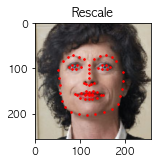

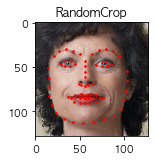

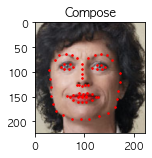

In [7]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## Iterating through the dataset
- 데이터셋이 샘플링 될 때마다:
    - file로부터 이미지 파일을 읽고
    - 이미지에 transform이 적용된다.
- for문을 이용해 iteration 진행하면 된다.

In [8]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


- 하지만 이렇게 for문을 사용해 iteration을 진행하는 경우 많은 정보를 소실하게 된다.
    - batching the data
    - shuffling the data
    - load the data in parallel using multiprocessing workkers
- torch.utils.data.DataLoader는 이런 feature들을 모두 제공하는 iterator이다.

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


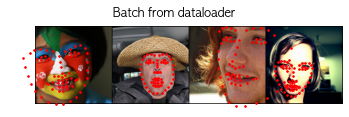

In [9]:
dataloader = DataLoader(transformed_dataset, batch_size = 4, shuffle = True, num_workers = 0)

# batch를 보여주기 위한 helper function
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break